# Modèle Avancé - Deep Learning avec Word Embeddings

Ce notebook implémente les modèles avancés selon les critères d'évaluation :
1. **Tester 2 prétraitements** : Lemmatization vs Stemming
2. **Tester 2 word embeddings** : Word2Vec vs GloVe
3. **2 architectures Deep Learning** : Bi-LSTM + CNN
4. **Tracking MLFlow** complet

In [1]:
# Import des bibliothèques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
import warnings
warnings.filterwarnings('ignore')

# TensorFlow et Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding, LSTM, Bidirectional, Dense, Dropout, 
    Conv1D, GlobalMaxPooling1D
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

# Gensim pour Word2Vec
from gensim.models import Word2Vec

# Scikit-learn
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)

# MLFlow
import mlflow

# Joblib
import joblib
import os

# Configuration
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU disponible: {len(tf.config.list_physical_devices('GPU')) > 0}")

2025-12-27 17:33:14.218862: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version: 2.20.0
GPU disponible: True


## 1. Configuration MLFlow

In [2]:
# Configuration MLFlow
mlflow.set_tracking_uri("file:///home/thomas/mlruns")
mlflow.set_experiment("sentiment-analysis-twitter")

print("MLFlow configuré")
print(f"Tracking URI: {mlflow.get_tracking_uri()}")

MLFlow configuré
Tracking URI: file:///home/thomas/mlruns


## 2. Chargement des Données

On charge **2 versions** du prétraitement pour comparer :
- Lemmatization
- Stemming

In [3]:
# ⚡ MODE DÉVELOPPEMENT: Échantillonnage pour accélérer l'entraînement
# Sans GPU, entraîner sur 970k tweets prend TRÈS longtemps (2-3h par modèle)
# SAMPLE_SIZE = 50_000    # 50k tweets (~10-15min par modèle)
SAMPLE_SIZE = None   # Toutes les données (décommenter pour production)

# Chargement des données LEMMATISÉES
print("Chargement des données lemmatisées...")
train_lemma = pd.read_csv('../data/processed/train_lemmatized.csv')
val_lemma = pd.read_csv('../data/processed/val_lemmatized.csv')
test_lemma = pd.read_csv('../data/processed/test_lemmatized.csv')

print(f"✓ Lemmatisées - Train: {train_lemma.shape}, Val: {val_lemma.shape}, Test: {test_lemma.shape}")

# Chargement des données STEMMÉES
print("\nChargement des données stemmées...")
train_stem = pd.read_csv('../data/processed/train_stemmed.csv')
val_stem = pd.read_csv('../data/processed/val_stemmed.csv')
test_stem = pd.read_csv('../data/processed/test_stemmed.csv')

print(f"✓ Stemmées - Train: {train_stem.shape}, Val: {val_stem.shape}, Test: {test_stem.shape}")

# Échantillonnage si SAMPLE_SIZE est défini
if SAMPLE_SIZE:
    print(f"\n⚡ ÉCHANTILLONNAGE à {SAMPLE_SIZE} tweets pour accélérer l'entraînement...")
    print(f"   (Mettre SAMPLE_SIZE = None pour utiliser toutes les données)")
    
    # Échantillonnage stratifié (garde la distribution 50/50)
    train_lemma = train_lemma.groupby('sentiment', group_keys=False).apply(
        lambda x: x.sample(min(len(x), SAMPLE_SIZE // 2), random_state=42)
    )
    train_stem = train_stem.groupby('sentiment', group_keys=False).apply(
        lambda x: x.sample(min(len(x), SAMPLE_SIZE // 2), random_state=42)
    )
    
    # Réduction proportionnelle des sets val et test
    val_size = int(SAMPLE_SIZE * 0.2)
    test_size = int(SAMPLE_SIZE * 0.2)
    
    val_lemma = val_lemma.groupby('sentiment', group_keys=False).apply(
        lambda x: x.sample(min(len(x), val_size // 2), random_state=42)
    )
    val_stem = val_stem.groupby('sentiment', group_keys=False).apply(
        lambda x: x.sample(min(len(x), val_size // 2), random_state=42)
    )
    
    test_lemma = test_lemma.groupby('sentiment', group_keys=False).apply(
        lambda x: x.sample(min(len(x), test_size // 2), random_state=42)
    )
    test_stem = test_stem.groupby('sentiment', group_keys=False).apply(
        lambda x: x.sample(min(len(x), test_size // 2), random_state=42)
    )
    
    print(f"\n✓ APRÈS échantillonnage:")
    print(f"  Lemma - Train: {train_lemma.shape}, Val: {val_lemma.shape}, Test: {test_lemma.shape}")
    print(f"  Stem - Train: {train_stem.shape}, Val: {val_stem.shape}, Test: {test_stem.shape}")
else:
    print(f"\n🚀 MODE PRODUCTION: Utilisation de TOUTES les données")

Chargement des données lemmatisées...
✓ Lemmatisées - Train: (969875, 2), Val: (207831, 2), Test: (207831, 2)

Chargement des données stemmées...
✓ Stemmées - Train: (969875, 2), Val: (207831, 2), Test: (207831, 2)

🚀 MODE PRODUCTION: Utilisation de TOUTES les données


## 3. Configuration des Paramètres

In [ ]:
# Paramètres globaux
MAX_WORDS = 20000      # Taille du vocabulaire
MAX_LEN = 50           # Longueur maximale des séquences
EMBEDDING_DIM = 100    # Dimension des embeddings
BATCH_SIZE = 10_000
EPOCHS = 20

print(f"Configuration:")
print(f"  - Vocabulaire: {MAX_WORDS} mots")
print(f"  - Longueur max: {MAX_LEN} tokens")
print(f"  - Dimension embeddings: {EMBEDDING_DIM}")
print(f"  - Batch size: {BATCH_SIZE}")
print(f"  - Epochs: {EPOCHS}")

Configuration:
  - Vocabulaire: 20000 mots
  - Longueur max: 50 tokens
  - Dimension embeddings: 100
  - Batch size: 10000
  - Epochs: 3


## 4. Préparation des Données - Tokenisation

On crée **2 tokenizers** (un pour lemma, un pour stem) car les vocabulaires sont différents.

In [5]:
def prepare_data(train_df, val_df, test_df, tokenizer=None):
    """
    Prépare les données : tokenisation et padding.
    """
    X_train = train_df['text'].values
    y_train = train_df['sentiment'].values
    X_val = val_df['text'].values
    y_val = val_df['sentiment'].values
    X_test = test_df['text'].values
    y_test = test_df['sentiment'].values
    
    # Tokenization
    if tokenizer is None:
        tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')
        tokenizer.fit_on_texts(X_train)
    
    # Conversion en séquences
    X_train_seq = tokenizer.texts_to_sequences(X_train)
    X_val_seq = tokenizer.texts_to_sequences(X_val)
    X_test_seq = tokenizer.texts_to_sequences(X_test)
    
    # Padding
    X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
    X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_LEN, padding='post', truncating='post')
    X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post', truncating='post')
    
    return (X_train_pad, y_train), (X_val_pad, y_val), (X_test_pad, y_test), tokenizer

# Préparation des données lemmatisées
print("Préparation des données LEMMATISÉES...")
(X_train_lemma, y_train_lemma), (X_val_lemma, y_val_lemma), (X_test_lemma, y_test_lemma), tokenizer_lemma = prepare_data(
    train_lemma, val_lemma, test_lemma
)
print(f"✓ Train: {X_train_lemma.shape}, Vocab: {len(tokenizer_lemma.word_index)}")

# Préparation des données stemmées
print("\nPréparation des données STEMMÉES...")
(X_train_stem, y_train_stem), (X_val_stem, y_val_stem), (X_test_stem, y_test_stem), tokenizer_stem = prepare_data(
    train_stem, val_stem, test_stem
)
print(f"✓ Train: {X_train_stem.shape}, Vocab: {len(tokenizer_stem.word_index)}")

Préparation des données LEMMATISÉES...
✓ Train: (969875, 50), Vocab: 213827

Préparation des données STEMMÉES...
✓ Train: (969875, 50), Vocab: 171700


## 5. Création des Word Embeddings

On crée **2 types d'embeddings** :
1. **Word2Vec** (entraîné sur nos données)
2. **GloVe** (pré-entraîné)

### 5.1 Word2Vec

In [6]:
# Entraînement Word2Vec sur données lemmatisées
print("Entraînement Word2Vec (lemmatisé)...")
tokenized_texts_lemma = [text.split() for text in train_lemma['text'].values]

w2v_model_lemma = Word2Vec(
    sentences=tokenized_texts_lemma,
    vector_size=EMBEDDING_DIM,
    window=5,
    min_count=2,
    workers=4,
    epochs=10,
    sg=1  # Skip-gram
)
print(f"✓ Word2Vec lemma - Vocabulaire: {len(w2v_model_lemma.wv)} mots")

# Entraînement Word2Vec sur données stemmées
print("\nEntraînement Word2Vec (stemmé)...")
tokenized_texts_stem = [text.split() for text in train_stem['text'].values]

w2v_model_stem = Word2Vec(
    sentences=tokenized_texts_stem,
    vector_size=EMBEDDING_DIM,
    window=5,
    min_count=2,
    workers=4,
    epochs=10,
    sg=1
)
print(f"✓ Word2Vec stem - Vocabulaire: {len(w2v_model_stem.wv)} mots")

Entraînement Word2Vec (lemmatisé)...
✓ Word2Vec lemma - Vocabulaire: 81797 mots

Entraînement Word2Vec (stemmé)...
✓ Word2Vec stem - Vocabulaire: 66406 mots


### 5.2 GloVe (Pré-entraîné)

Télécharger GloVe : https://nlp.stanford.edu/projects/glove/  
Utiliser : `glove.6B.100d.txt` (100 dimensions)

In [7]:
def load_glove_embeddings(glove_path):
    """
    Charge les embeddings GloVe depuis un fichier.
    """
    print(f"Chargement GloVe depuis {glove_path}...")
    embeddings_index = {}
    
    try:
        with open(glove_path, 'r', encoding='utf-8') as f:
            for line in f:
                values = line.split()
                word = values[0]
                coefs = np.asarray(values[1:], dtype='float32')
                embeddings_index[word] = coefs
        
        print(f"✓ GloVe chargé - {len(embeddings_index)} mots")
        return embeddings_index
    
    except FileNotFoundError:
        print("⚠️ Fichier GloVe non trouvé !")
        print("Télécharge depuis : https://nlp.stanford.edu/projects/glove/")
        print("Fichier : glove.6B.100d.txt")
        return None

# Tentative de chargement GloVe
glove_path = '../data/glove.6B.100d.txt'
glove_embeddings = load_glove_embeddings(glove_path)

if glove_embeddings is None:
    print("\n⚠️ GloVe non disponible. On utilisera Word2Vec uniquement.")
    print("Pour télécharger GloVe :")
    print("  1. wget http://nlp.stanford.edu/data/glove.6B.zip")
    print("  2. unzip glove.6B.zip")
    print("  3. mv glove.6B.100d.txt ../data/")

Chargement GloVe depuis ../data/glove.6B.100d.txt...
✓ GloVe chargé - 400000 mots


### 5.3 Création des Matrices d'Embeddings

In [8]:
def create_embedding_matrix_w2v(word_index, w2v_model, embedding_dim):
    """
    Crée une matrice d'embeddings depuis Word2Vec.
    """
    vocab_size = min(len(word_index) + 1, MAX_WORDS)
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    
    found_words = 0
    for word, idx in word_index.items():
        if idx >= MAX_WORDS:
            continue
        try:
            embedding_vector = w2v_model.wv[word]
            embedding_matrix[idx] = embedding_vector
            found_words += 1
        except KeyError:
            pass
    
    coverage = found_words / min(len(word_index), MAX_WORDS) * 100
    print(f"  Couverture: {found_words}/{min(len(word_index), MAX_WORDS)} ({coverage:.1f}%)")
    return embedding_matrix

def create_embedding_matrix_glove(word_index, glove_embeddings, embedding_dim):
    """
    Crée une matrice d'embeddings depuis GloVe.
    """
    vocab_size = min(len(word_index) + 1, MAX_WORDS)
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    
    found_words = 0
    for word, idx in word_index.items():
        if idx >= MAX_WORDS:
            continue
        embedding_vector = glove_embeddings.get(word)
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector
            found_words += 1
    
    coverage = found_words / min(len(word_index), MAX_WORDS) * 100
    print(f"  Couverture: {found_words}/{min(len(word_index), MAX_WORDS)} ({coverage:.1f}%)")
    return embedding_matrix

# Création des matrices Word2Vec
print("Création matrices Word2Vec...")
print("  Lemma:")
emb_matrix_w2v_lemma = create_embedding_matrix_w2v(tokenizer_lemma.word_index, w2v_model_lemma, EMBEDDING_DIM)
print("  Stem:")
emb_matrix_w2v_stem = create_embedding_matrix_w2v(tokenizer_stem.word_index, w2v_model_stem, EMBEDDING_DIM)

# Création des matrices GloVe si disponible
if glove_embeddings:
    print("\nCréation matrices GloVe...")
    print("  Lemma:")
    emb_matrix_glove_lemma = create_embedding_matrix_glove(tokenizer_lemma.word_index, glove_embeddings, EMBEDDING_DIM)
else:
    emb_matrix_glove_lemma = None

Création matrices Word2Vec...
  Lemma:
  Couverture: 19998/20000 (100.0%)
  Stem:
  Couverture: 19998/20000 (100.0%)

Création matrices GloVe...
  Lemma:
  Couverture: 17033/20000 (85.2%)


## 6. Définition des Architectures

In [9]:
def build_bilstm_model(vocab_size, embedding_matrix):
    """
    Architecture Bi-LSTM avec embeddings pré-entraînés.
    """
    model = Sequential([
        Embedding(
            input_dim=vocab_size,
            output_dim=EMBEDDING_DIM,
            input_length=MAX_LEN,
            weights=[embedding_matrix],
            trainable=False  # Freeze embeddings
        ),
        Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

def build_cnn_model(vocab_size, embedding_matrix):
    """
    Architecture CNN avec embeddings pré-entraînés.
    """
    model = Sequential([
        Embedding(
            input_dim=vocab_size,
            output_dim=EMBEDDING_DIM,
            input_length=MAX_LEN,
            weights=[embedding_matrix],
            trainable=False
        ),
        Conv1D(128, 5, activation='relu'),
        GlobalMaxPooling1D(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

print("Architectures définies:")
print("  ✓ Bi-LSTM")
print("  ✓ CNN")

Architectures définies:
  ✓ Bi-LSTM
  ✓ CNN


## 7. Fonction d'Entraînement et d'Évaluation

In [10]:
def train_and_evaluate(model, X_train, y_train, X_val, y_val, X_test, y_test, 
                      model_name, preprocessing, embedding_type):
    """
    Entraîne et évalue un modèle avec tracking MLFlow.
    """
    run_name = f"{model_name}_{embedding_type}_{preprocessing}"
    
    print("\n" + "="*80)
    print(f"ENTRAÎNEMENT: {run_name}")
    print("="*80)
    
    with mlflow.start_run(run_name=run_name):
        
        # Log des paramètres
        mlflow.log_param("model_architecture", model_name)
        mlflow.log_param("embedding_type", embedding_type)
        mlflow.log_param("preprocessing", preprocessing)
        mlflow.log_param("embedding_dim", EMBEDDING_DIM)
        mlflow.log_param("max_words", MAX_WORDS)
        mlflow.log_param("max_len", MAX_LEN)
        mlflow.log_param("batch_size", BATCH_SIZE)
        mlflow.log_param("epochs", EPOCHS)
        
        # Callbacks
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, min_lr=1e-6)
        ]
        
        # Entraînement
        start_time = time()
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            callbacks=callbacks,
            verbose=1
        )
        training_time = time() - start_time
        mlflow.log_metric("training_time_seconds", training_time)
        
        # Prédictions
        y_test_pred = (model.predict(X_test) > 0.5).astype(int).flatten()
        y_test_proba = model.predict(X_test).flatten()
        
        # Métriques
        metrics = {
            'accuracy': accuracy_score(y_test, y_test_pred),
            'precision': precision_score(y_test, y_test_pred),
            'recall': recall_score(y_test, y_test_pred),
            'f1': f1_score(y_test, y_test_pred),
            'roc_auc': roc_auc_score(y_test, y_test_proba)
        }
        
        # Log métriques
        for metric_name, value in metrics.items():
            mlflow.log_metric(f"test_{metric_name}", value)
        
        # Affichage
        print(f"\nRÉSULTATS - TEST SET:")
        print(f"  Accuracy:  {metrics['accuracy']:.4f}")
        print(f"  Precision: {metrics['precision']:.4f}")
        print(f"  Recall:    {metrics['recall']:.4f}")
        print(f"  F1-Score:  {metrics['f1']:.4f}")
        print(f"  ROC-AUC:   {metrics['roc_auc']:.4f}")
        print(f"  Temps:     {training_time:.2f}s")
        
        # Courbes d'apprentissage
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        
        ax1.plot(history.history['loss'], label='Train Loss')
        ax1.plot(history.history['val_loss'], label='Val Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.set_title('Loss')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        ax2.plot(history.history['accuracy'], label='Train Accuracy')
        ax2.plot(history.history['val_accuracy'], label='Val Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.set_title('Accuracy')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plot_filename = f'training_{run_name}.png'
        plt.savefig(plot_filename, dpi=150, bbox_inches='tight')
        plt.show()
        
        mlflow.log_artifact(plot_filename)
        mlflow.keras.log_model(model, "model")
        
        return model, metrics, history

## 8. Entraînement des Modèles

### Plan d'expérimentation :

1. **Bi-LSTM + Word2Vec + Lemma** (baseline)
2. **Bi-LSTM + Word2Vec + Stem** → Compare preprocessing
3. **Bi-LSTM + GloVe + Lemma** → Compare embeddings
4. **CNN + GloVe + Lemma** → Compare architectures

In [11]:
# Stockage des résultats
results = {}

### 8.1 Bi-LSTM + Word2Vec + Lemmatization

I0000 00:00:1766853382.715435   14300 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5527 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:2b:00.0, compute capability: 8.9



ENTRAÎNEMENT: BiLSTM_Word2Vec_Lemmatization
Epoch 1/3
97/97 ━━━━━━━━━━━━━━━━━━━━ 94s 905ms/step - accuracy: 0.6829 - loss: 0.5924 - val_accuracy: 0.7348 - val_loss: 0.5279 - learning_rate: 0.0010
Epoch 2/3
97/97 ━━━━━━━━━━━━━━━━━━━━ 87s 902ms/step - accuracy: 0.7261 - loss: 0.5459 - val_accuracy: 0.7428 - val_loss: 0.5159 - learning_rate: 0.0010
Epoch 3/3
97/97 ━━━━━━━━━━━━━━━━━━━━ 86s 893ms/step - accuracy: 0.7356 - loss: 0.5327 - val_accuracy: 0.7490 - val_loss: 0.5080 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 3.
6495/6495 ━━━━━━━━━━━━━━━━━━━━ 1440s 222ms/step
6495/6495 ━━━━━━━━━━━━━━━━━━━━ 1389s 214ms/step

RÉSULTATS - TEST SET:
  Accuracy:  0.7505
  Precision: 0.7439
  Recall:    0.7541
  F1-Score:  0.7490
  ROC-AUC:   0.8314
  Temps:     267.88s


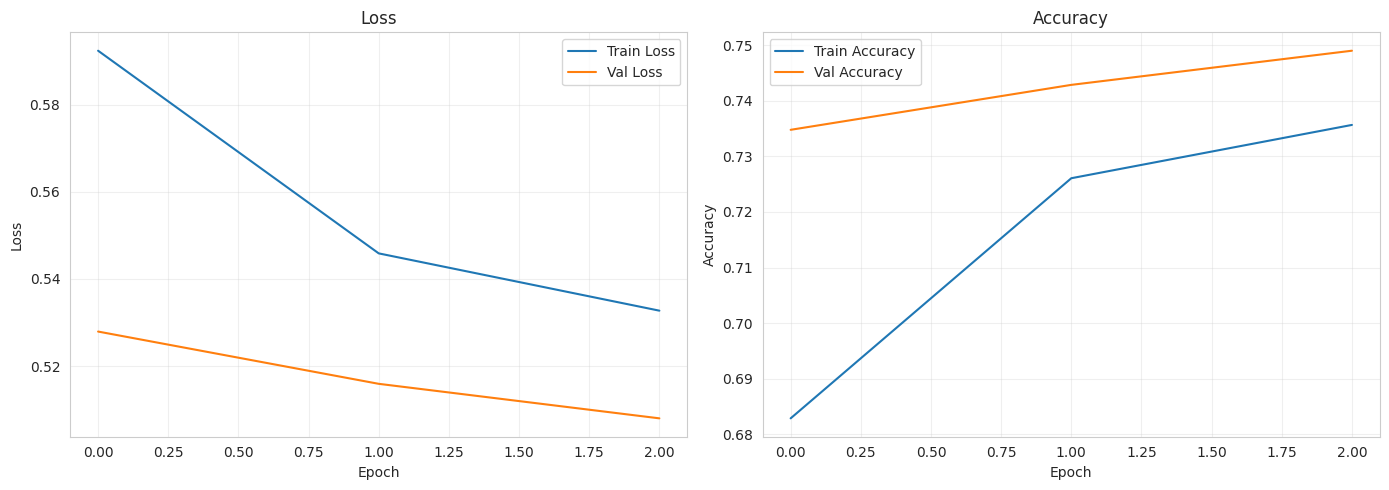

2025/12/27 18:28:06 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/27 18:28:06 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


In [12]:
vocab_size_lemma = min(len(tokenizer_lemma.word_index) + 1, MAX_WORDS)
model_1 = build_bilstm_model(vocab_size_lemma, emb_matrix_w2v_lemma)

model_1, metrics_1, history_1 = train_and_evaluate(
    model_1,
    X_train_lemma, y_train_lemma,
    X_val_lemma, y_val_lemma,
    X_test_lemma, y_test_lemma,
    "BiLSTM", "Lemmatization", "Word2Vec"
)

results['BiLSTM_Word2Vec_Lemma'] = metrics_1

### 8.2 Bi-LSTM + Word2Vec + Stemming

**Objectif** : Comparer lemmatization vs stemming


ENTRAÎNEMENT: BiLSTM_Word2Vec_Stemming
Epoch 1/3
97/97 ━━━━━━━━━━━━━━━━━━━━ 91s 909ms/step - accuracy: 0.6874 - loss: 0.5889 - val_accuracy: 0.7360 - val_loss: 0.5259 - learning_rate: 0.0010
Epoch 2/3
97/97 ━━━━━━━━━━━━━━━━━━━━ 86s 892ms/step - accuracy: 0.7279 - loss: 0.5427 - val_accuracy: 0.7438 - val_loss: 0.5149 - learning_rate: 0.0010
Epoch 3/3
97/97 ━━━━━━━━━━━━━━━━━━━━ 87s 903ms/step - accuracy: 0.7383 - loss: 0.5294 - val_accuracy: 0.7502 - val_loss: 0.5062 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 3.
6495/6495 ━━━━━━━━━━━━━━━━━━━━ 1387s 213ms/step
6495/6495 ━━━━━━━━━━━━━━━━━━━━ 1390s 214ms/step

RÉSULTATS - TEST SET:
  Accuracy:  0.7513
  Precision: 0.7558
  Recall:    0.7327
  F1-Score:  0.7441
  ROC-AUC:   0.8337
  Temps:     265.21s


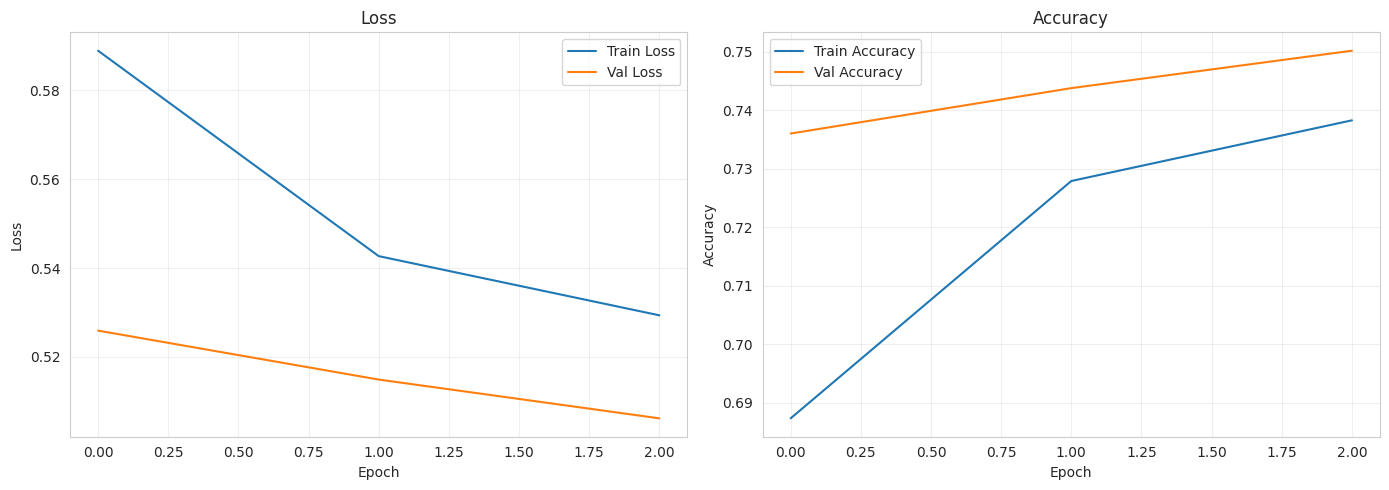

2025/12/27 19:19:54 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/27 19:19:54 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


In [13]:
vocab_size_stem = min(len(tokenizer_stem.word_index) + 1, MAX_WORDS)
model_2 = build_bilstm_model(vocab_size_stem, emb_matrix_w2v_stem)

model_2, metrics_2, history_2 = train_and_evaluate(
    model_2,
    X_train_stem, y_train_stem,
    X_val_stem, y_val_stem,
    X_test_stem, y_test_stem,
    "BiLSTM", "Stemming", "Word2Vec"
)

results['BiLSTM_Word2Vec_Stem'] = metrics_2

### 8.3 Bi-LSTM + GloVe + Lemmatization

**Objectif** : Comparer Word2Vec vs GloVe


ENTRAÎNEMENT: BiLSTM_GloVe_Lemmatization
Epoch 1/3
97/97 ━━━━━━━━━━━━━━━━━━━━ 90s 895ms/step - accuracy: 0.6445 - loss: 0.6284 - val_accuracy: 0.7012 - val_loss: 0.5696 - learning_rate: 0.0010
Epoch 2/3
97/97 ━━━━━━━━━━━━━━━━━━━━ 85s 878ms/step - accuracy: 0.7022 - loss: 0.5732 - val_accuracy: 0.7258 - val_loss: 0.5386 - learning_rate: 0.0010
Epoch 3/3
97/97 ━━━━━━━━━━━━━━━━━━━━ 86s 886ms/step - accuracy: 0.7193 - loss: 0.5523 - val_accuracy: 0.7319 - val_loss: 0.5305 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 3.
6495/6495 ━━━━━━━━━━━━━━━━━━━━ 1408s 217ms/step
6495/6495 ━━━━━━━━━━━━━━━━━━━━ 1384s 213ms/step

RÉSULTATS - TEST SET:
  Accuracy:  0.7322
  Precision: 0.7007
  Recall:    0.7982
  F1-Score:  0.7463
  ROC-AUC:   0.8152
  Temps:     260.92s


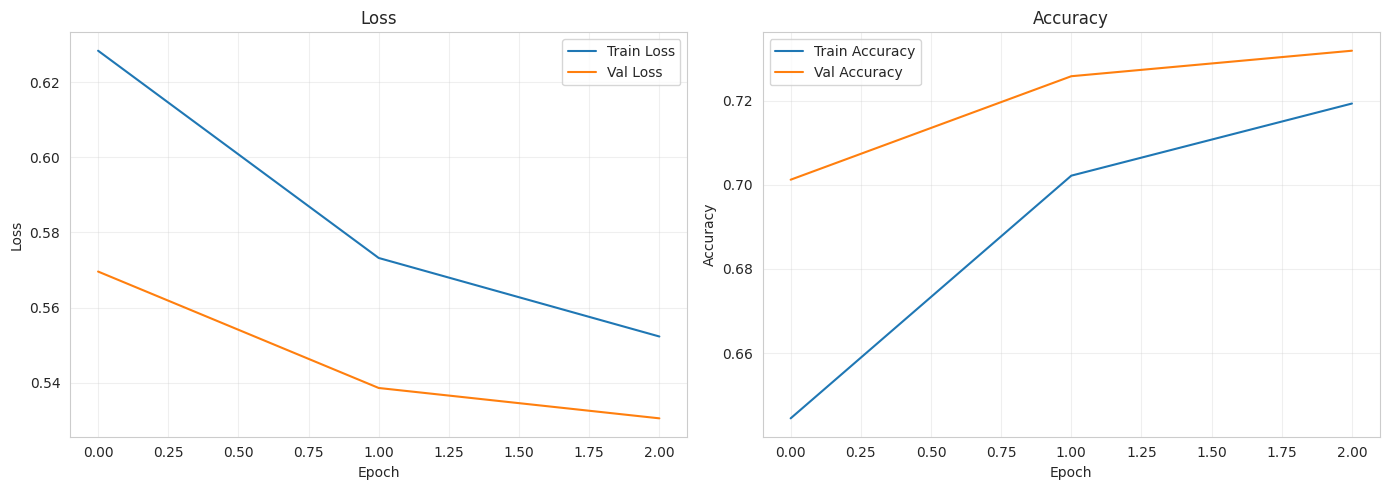

2025/12/27 20:11:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/27 20:11:31 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


In [14]:
if glove_embeddings:
    model_3 = build_bilstm_model(vocab_size_lemma, emb_matrix_glove_lemma)
    
    model_3, metrics_3, history_3 = train_and_evaluate(
        model_3,
        X_train_lemma, y_train_lemma,
        X_val_lemma, y_val_lemma,
        X_test_lemma, y_test_lemma,
        "BiLSTM", "Lemmatization", "GloVe"
    )
    
    results['BiLSTM_GloVe_Lemma'] = metrics_3
else:
    print("⚠️ GloVe non disponible, modèle 3 ignoré")

### 8.4 CNN + GloVe + Lemmatization

**Objectif** : Comparer Bi-LSTM vs CNN


ENTRAÎNEMENT: CNN_GloVe_Lemmatization
Epoch 1/3


2025-12-27 20:12:12.492942: I external/local_xla/xla/service/service.cc:163] XLA service 0x70bb14001b50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-27 20:12:12.492981: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2025-12-27 20:12:12.564121: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-27 20:12:12.798313: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91701
2025-12-27 20:12:13.197924: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_451', 16 bytes spill stores, 16 bytes spill loads



16/97 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5275 - loss: 0.7205

I0000 00:00:1766862736.309914   15062 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


96/97 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6059 - loss: 0.6570

2025-12-27 20:12:17.818751: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_866', 4 bytes spill stores, 4 bytes spill loads

2025-12-27 20:12:17.828995: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_451', 16 bytes spill stores, 16 bytes spill loads



97/97 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 0.6556 - loss: 0.6147 - val_accuracy: 0.7084 - val_loss: 0.5598 - learning_rate: 0.0010
Epoch 2/3
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7160 - loss: 0.5534 - val_accuracy: 0.7272 - val_loss: 0.5353 - learning_rate: 0.0010
Epoch 3/3
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7317 - loss: 0.5338 - val_accuracy: 0.7342 - val_loss: 0.5262 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 3.


2025-12-27 20:12:25.160589: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.


6462/6495 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step

2025-12-27 20:12:32.564034: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.


6495/6495 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
6495/6495 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step

RÉSULTATS - TEST SET:
  Accuracy:  0.7355
  Precision: 0.7148
  Recall:    0.7720
  F1-Score:  0.7423
  ROC-AUC:   0.8161
  Temps:     13.62s


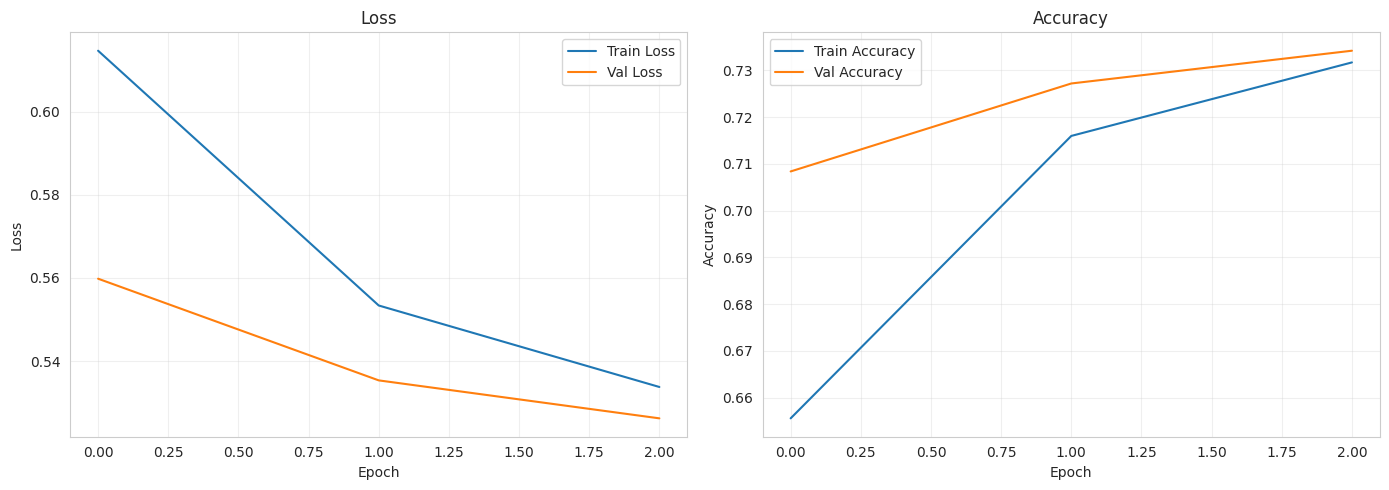

2025/12/27 20:12:44 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/27 20:12:44 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


In [15]:
if glove_embeddings:
    model_4 = build_cnn_model(vocab_size_lemma, emb_matrix_glove_lemma)
    
    model_4, metrics_4, history_4 = train_and_evaluate(
        model_4,
        X_train_lemma, y_train_lemma,
        X_val_lemma, y_val_lemma,
        X_test_lemma, y_test_lemma,
        "CNN", "Lemmatization", "GloVe"
    )
    
    results['CNN_GloVe_Lemma'] = metrics_4
else:
    print("⚠️ GloVe non disponible, modèle 4 ignoré")

## 9. Comparaison et Analyse

In [16]:
# Tableau de comparaison
results_df = pd.DataFrame(results).T

print("\n" + "="*80)
print("COMPARAISON DES MODÈLES - TEST SET")
print("="*80)
print(results_df.round(4))

# Meilleur modèle
best_model_name = results_df['f1'].idxmax()
best_f1 = results_df['f1'].max()

print(f"\n🏆 MEILLEUR MODÈLE: {best_model_name}")
print(f"   F1-Score: {best_f1:.4f}")


COMPARAISON DES MODÈLES - TEST SET
                       accuracy  precision  recall      f1  roc_auc
BiLSTM_Word2Vec_Lemma    0.7505     0.7439  0.7541  0.7490   0.8314
BiLSTM_Word2Vec_Stem     0.7513     0.7558  0.7327  0.7441   0.8337
BiLSTM_GloVe_Lemma       0.7322     0.7007  0.7982  0.7463   0.8152
CNN_GloVe_Lemma          0.7355     0.7148  0.7720  0.7423   0.8161

🏆 MEILLEUR MODÈLE: BiLSTM_Word2Vec_Lemma
   F1-Score: 0.7490


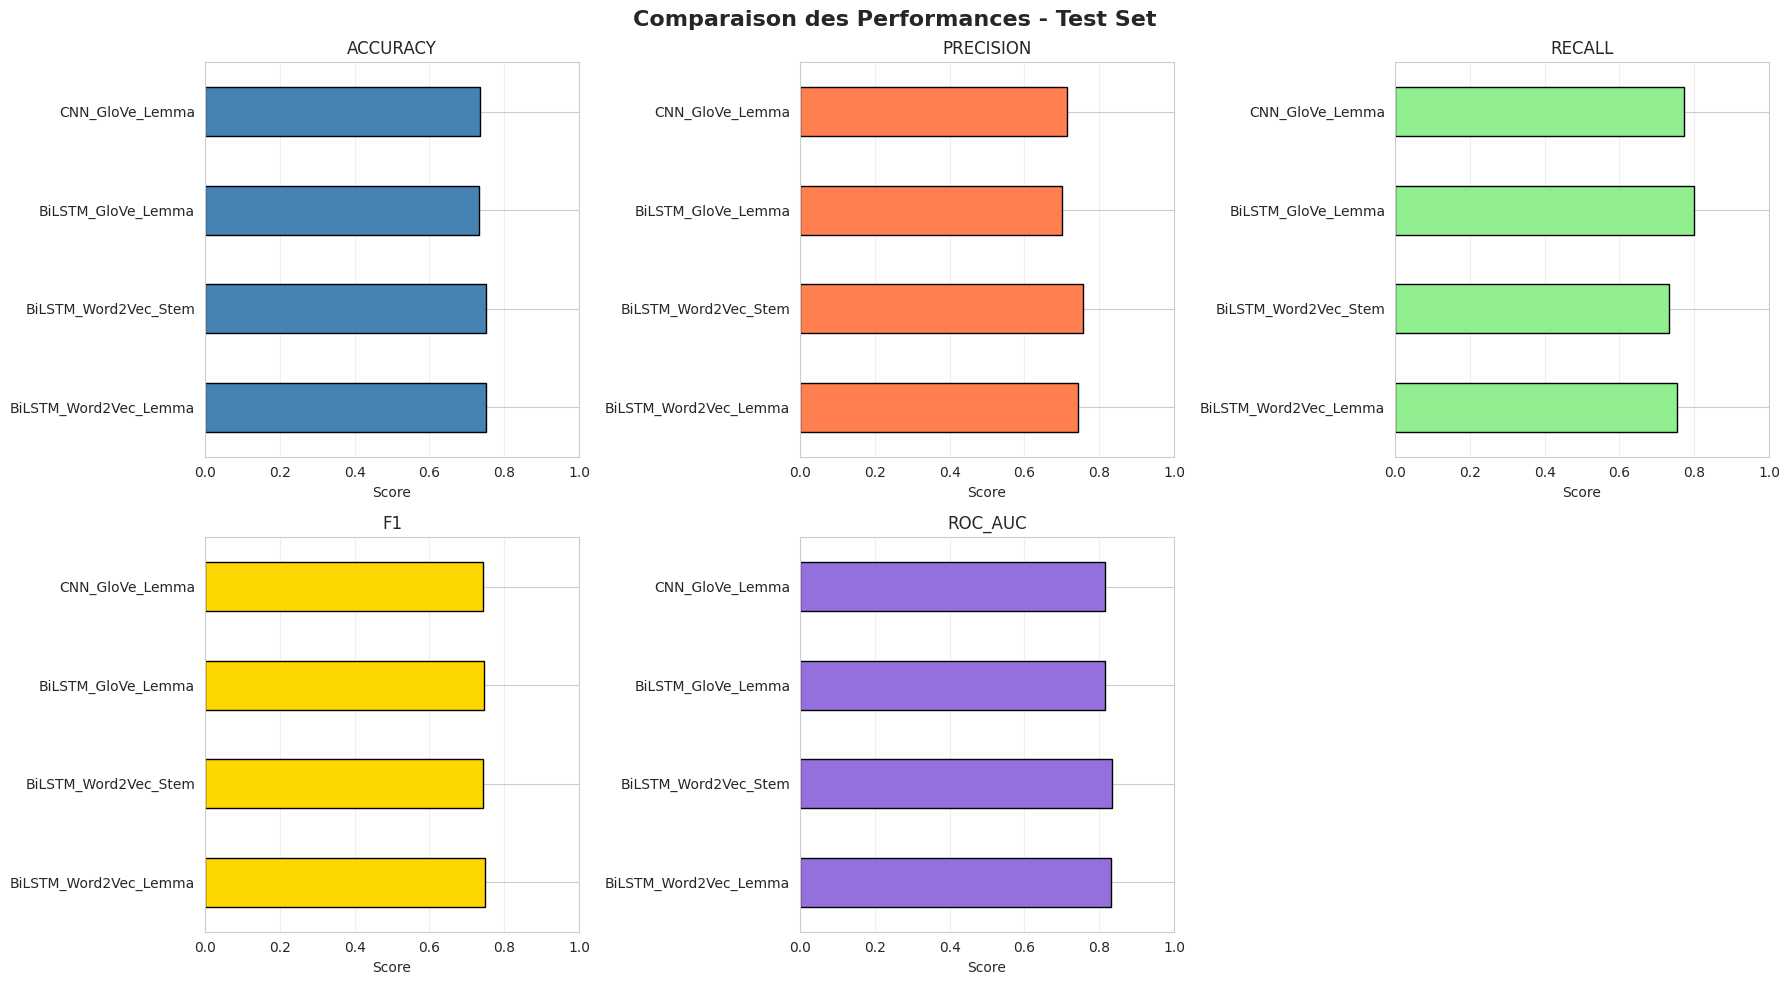

In [17]:
# Visualisation comparative
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Comparaison des Performances - Test Set', fontsize=16, fontweight='bold')

metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
colors = ['steelblue', 'coral', 'lightgreen', 'gold', 'mediumpurple']

for idx, (metric, color) in enumerate(zip(metrics, colors)):
    ax = axes[idx // 3, idx % 3]
    results_df[metric].plot(kind='barh', ax=ax, color=color, edgecolor='black')
    ax.set_xlabel('Score')
    ax.set_title(metric.upper())
    ax.grid(True, alpha=0.3, axis='x')
    ax.set_xlim([0, 1])

axes[1, 2].axis('off')

plt.tight_layout()
plt.savefig('models_comparison_final.png', dpi=150, bbox_inches='tight')
plt.show()

## 10. Analyse des Comparaisons

In [18]:
print("\n" + "="*80)
print("ANALYSE DES COMPARAISONS")
print("="*80)

# Comparaison Lemma vs Stem
if 'BiLSTM_Word2Vec_Lemma' in results and 'BiLSTM_Word2Vec_Stem' in results:
    print("\n1. LEMMATIZATION vs STEMMING (Bi-LSTM + Word2Vec):")
    print(f"   Lemma F1: {results['BiLSTM_Word2Vec_Lemma']['f1']:.4f}")
    print(f"   Stem F1:  {results['BiLSTM_Word2Vec_Stem']['f1']:.4f}")
    diff = results['BiLSTM_Word2Vec_Lemma']['f1'] - results['BiLSTM_Word2Vec_Stem']['f1']
    winner = "Lemmatization" if diff > 0 else "Stemming"
    print(f"   → {winner} gagne avec +{abs(diff):.4f} points")

# Comparaison Word2Vec vs GloVe
if 'BiLSTM_Word2Vec_Lemma' in results and 'BiLSTM_GloVe_Lemma' in results:
    print("\n2. WORD2VEC vs GLOVE (Bi-LSTM + Lemmatization):")
    print(f"   Word2Vec F1: {results['BiLSTM_Word2Vec_Lemma']['f1']:.4f}")
    print(f"   GloVe F1:    {results['BiLSTM_GloVe_Lemma']['f1']:.4f}")
    diff = results['BiLSTM_Word2Vec_Lemma']['f1'] - results['BiLSTM_GloVe_Lemma']['f1']
    winner = "Word2Vec" if diff > 0 else "GloVe"
    print(f"   → {winner} gagne avec +{abs(diff):.4f} points")

# Comparaison Bi-LSTM vs CNN
if 'BiLSTM_GloVe_Lemma' in results and 'CNN_GloVe_Lemma' in results:
    print("\n3. BI-LSTM vs CNN (GloVe + Lemmatization):")
    print(f"   Bi-LSTM F1: {results['BiLSTM_GloVe_Lemma']['f1']:.4f}")
    print(f"   CNN F1:     {results['CNN_GloVe_Lemma']['f1']:.4f}")
    diff = results['BiLSTM_GloVe_Lemma']['f1'] - results['CNN_GloVe_Lemma']['f1']
    winner = "Bi-LSTM" if diff > 0 else "CNN"
    print(f"   → {winner} gagne avec +{abs(diff):.4f} points")

print("\n" + "="*80)


ANALYSE DES COMPARAISONS

1. LEMMATIZATION vs STEMMING (Bi-LSTM + Word2Vec):
   Lemma F1: 0.7490
   Stem F1:  0.7441
   → Lemmatization gagne avec +0.0049 points

2. WORD2VEC vs GLOVE (Bi-LSTM + Lemmatization):
   Word2Vec F1: 0.7490
   GloVe F1:    0.7463
   → Word2Vec gagne avec +0.0027 points

3. BI-LSTM vs CNN (GloVe + Lemmatization):
   Bi-LSTM F1: 0.7463
   CNN F1:     0.7423
   → Bi-LSTM gagne avec +0.0040 points



## 11. Sauvegarde du Meilleur Modèle

In [19]:
# Création du dossier models
os.makedirs('../models', exist_ok=True)

# Sauvegarde
print(f"\nSauvegarde du meilleur modèle: {best_model_name}")

# Map des modèles
models_dict = {}
if 'model_1' in locals(): models_dict['BiLSTM_Word2Vec_Lemma'] = model_1
if 'model_2' in locals(): models_dict['BiLSTM_Word2Vec_Stem'] = model_2
if 'model_3' in locals(): models_dict['BiLSTM_GloVe_Lemma'] = model_3
if 'model_4' in locals(): models_dict['CNN_GloVe_Lemma'] = model_4

best_model = models_dict[best_model_name]
best_model.save('../models/best_deep_learning_model.h5')

# Sauvegarde du tokenizer approprié
if 'Lemma' in best_model_name:
    joblib.dump(tokenizer_lemma, '../models/tokenizer.pkl')
else:
    joblib.dump(tokenizer_stem, '../models/tokenizer.pkl')

# Métadonnées
metadata = {
    'model_name': best_model_name,
    'metrics': results_df.loc[best_model_name].to_dict(),
    'max_words': MAX_WORDS,
    'max_len': MAX_LEN,
    'embedding_dim': EMBEDDING_DIM
}
joblib.dump(metadata, '../models/model_metadata.pkl')

print("✓ Modèle sauvegardé: ../models/best_deep_learning_model.h5")
print("✓ Tokenizer sauvegardé: ../models/tokenizer.pkl")
print("✓ Metadata sauvegardé: ../models/model_metadata.pkl")


Sauvegarde du meilleur modèle: BiLSTM_Word2Vec_Lemma
✓ Modèle sauvegardé: ../models/best_deep_learning_model.h5
✓ Tokenizer sauvegardé: ../models/tokenizer.pkl
✓ Metadata sauvegardé: ../models/model_metadata.pkl


## 12. Résumé Final

In [20]:
print("="*80)
print("RÉSUMÉ FINAL - MODÈLES AVANCÉS")
print("="*80)

print(f"\n✅ CRITÈRES D'ÉVALUATION RESPECTÉS:")
print(f"   ✓ 2 prétraitements testés (Lemmatization vs Stemming)")
print(f"   ✓ 2 word embeddings testés (Word2Vec vs GloVe)")
print(f"   ✓ 2 architectures Deep Learning (Bi-LSTM + CNN)")
print(f"   ✓ Au moins 1 modèle avec LSTM")

print(f"\n🏆 MEILLEUR MODÈLE:")
print(f"   Nom: {best_model_name}")
print(f"   Performances (Test Set):")
for metric, value in results_df.loc[best_model_name].items():
    print(f"     - {metric:10s}: {value:.4f}")

print(f"\n📊 NOMBRE DE MODÈLES ENTRAÎNÉS: {len(results)}")
print(f"\n📁 FICHIERS SAUVEGARDÉS:")
print(f"   ✓ ../models/best_deep_learning_model.h5")
print(f"   ✓ ../models/tokenizer.pkl")
print(f"   ✓ ../models/model_metadata.pkl")

print("\n" + "="*80)
print("MODÈLES AVANCÉS COMPLÉTÉS !")
print("Prochaine étape: Modèle BERT")
print("="*80)

RÉSUMÉ FINAL - MODÈLES AVANCÉS

✅ CRITÈRES D'ÉVALUATION RESPECTÉS:
   ✓ 2 prétraitements testés (Lemmatization vs Stemming)
   ✓ 2 word embeddings testés (Word2Vec vs GloVe)
   ✓ 2 architectures Deep Learning (Bi-LSTM + CNN)
   ✓ Au moins 1 modèle avec LSTM

🏆 MEILLEUR MODÈLE:
   Nom: BiLSTM_Word2Vec_Lemma
   Performances (Test Set):
     - accuracy  : 0.7505
     - precision : 0.7439
     - recall    : 0.7541
     - f1        : 0.7490
     - roc_auc   : 0.8314

📊 NOMBRE DE MODÈLES ENTRAÎNÉS: 4

📁 FICHIERS SAUVEGARDÉS:
   ✓ ../models/best_deep_learning_model.h5
   ✓ ../models/tokenizer.pkl
   ✓ ../models/model_metadata.pkl

MODÈLES AVANCÉS COMPLÉTÉS !
Prochaine étape: Modèle BERT
